<a href="https://colab.research.google.com/github/Mon82sj/VOIS/blob/main/recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
#FINAL CODE
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset
df = pd.read_csv('student_domain_course_ratings.csv')

# Rename 'Ratings' to 'Rating'
df.rename(columns={'Ratings': 'Rating'}, inplace=True)

# Normalize case
df['Domain'] = df['Domain'].str.lower()
df['Course'] = df['Course'].str.lower()

# Combine 'Domain' and 'Course' columns into a single 'content' column for TF-IDF
df['content'] = df['Domain'] + " " + df['Course']

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the content to generate the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(df['content'])

# Calculate the cosine similarity between all courses
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a series with the course names as the index, handling duplicates
course_indices = pd.Series(df.index, index=df['Course']).drop_duplicates()

def recommend_courses(search_input, cosine_sim=cosine_sim):
    search_input = search_input.lower()  # Normalize user input case

    if search_input in course_indices.index:
        # User input is a course
        idx_list = course_indices[search_input]

        if len(idx_list) == 0:
            print("Course not found.")
            return pd.DataFrame(columns=['Course', 'Rating'])

        # Use the first index in case of multiple entries
        idx = idx_list[0]
        course_domain = df.at[idx, 'Domain']

        # List courses in the same domain
        domain_courses = df[df['Domain'] == course_domain]

        # Sort courses by rating
        domain_courses_sorted = domain_courses.sort_values(by='Rating', ascending=False).head(20)
        return domain_courses_sorted[['Course', 'Rating']]

    elif search_input in df['Domain'].values:
        # User input is a domain
        domain_courses = df[df['Domain'] == search_input]

        # Sort courses by rating
        domain_courses_sorted = domain_courses.sort_values(by='Rating', ascending=False).head(20)
        return domain_courses_sorted[['Course', 'Rating']]

    else:
        print("Input not found.")
        return pd.DataFrame(columns=['Course', 'Rating'])

# Example: Recommend courses based on user input
user_input = input("Enter the course name : ")  # Replace with dynamic user input if needed
recommended_courses_df = recommend_courses(user_input)
print("Recommended courses:")
print(recommended_courses_df)


Enter the course name : cloud computing
Recommended courses:
                Course  Rating
67      cloud security       5
72      cloud security       5
46  azure fundamentals       4
16      aws essentials       3
26      aws essentials       3
33      aws essentials       2
56        cloud basics       2
1         cloud basics       0
3       cloud security       0
13        cloud basics       0
29        cloud basics       0
94      aws essentials       0
96        cloud basics       0


In [61]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357293 sha256=d2ff2ff07ae7558ebc54c4efa18f138f3e69c4cd3e632b67b782bf0801af6fc2
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [69]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate
import pandas as pd

# Load your dataset
df = pd.read_csv('student_domain_course_ratings.csv')

# Define a Reader for surprise
reader = Reader(rating_scale=(df['Rating'].min(), df['Rating'].max()))

# Load the dataset into Surprise
data = Dataset.load_from_df(df[['Student ID', 'Course', 'Rating']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Initialize and train the SVD model
model = SVD()
model.fit(trainset)

# Evaluate the model
predictions = model.test(testset)
accuracy = accuracy.rmse(predictions)
print(f'RMSE: {accuracy}')

# Cross-Validation
cv_results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)


RMSE: 1.7287
RMSE: 1.7287027744965764
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.7731  1.9312  1.8571  1.4719  1.4902  1.7047  0.1894  
Fit time          0.01    0.01    0.02    0.01    0.01    0.01    0.00    
Test time         0.01    0.00    0.00    0.00    0.00    0.00    0.00    


In [190]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def load_and_prepare_data(file_path):
    """Load dataset and prepare it for processing."""
    df = pd.read_csv(file_path)
    df.rename(columns={'Ratings': 'Rating'}, inplace=True)
    df['Domain'] = df['Domain'].str.lower()
    df['Course'] = df['Course'].str.lower()
    df['content'] = df['Domain'] + " " + df['Course']
    return df

def compute_tfidf_matrix(df):
    """Compute TF-IDF matrix from the 'content' column."""
    tfidf = TfidfVectorizer(stop_words='english')
    return tfidf.fit_transform(df['content'])

def calculate_cosine_similarity(tfidf_matrix):
    """Calculate cosine similarity matrix."""
    return cosine_similarity(tfidf_matrix, tfidf_matrix)

def create_course_index(df):
    """Create a Series with the course names as the index."""
    return pd.Series(df.index, index=df['Course']).drop_duplicates()

def get_domain_courses(df, domain):
    """Get courses for a given domain and sort by rating."""
    domain_courses = df[df['Domain'] == domain]
    return domain_courses.sort_values(by='Rating', ascending=False).head(20)[['Course', 'Rating']]

def recommend_courses(search_input, df, cosine_sim, course_indices):
    """Recommend courses based on user input."""
    search_input = search_input.lower()
    if search_input in course_indices.index:
        idx_list = course_indices[search_input]
        if len(idx_list) == 0:
            print("Course not found.")
            return pd.DataFrame(columns=['Course', 'Rating'])
        idx = idx_list[0]
        course_domain = df.at[idx, 'Domain']
        return get_domain_courses(df, course_domain)
    elif search_input in df['Domain'].values:
        return get_domain_courses(df, search_input)
    else:
        print("Input not found.")
        return pd.DataFrame(columns=['Course', 'Rating'])

# Main execution
if __name__ == "__main__":
    df = load_and_prepare_data('student_domain_course_ratings.csv')
    tfidf_matrix = compute_tfidf_matrix(df)
    cosine_sim = calculate_cosine_similarity(tfidf_matrix)
    course_indices = create_course_index(df)

    user_input = input("Enter the course name or domain: ")  # Replace with dynamic user input if needed
    recommended_courses_df = recommend_courses(user_input, df, cosine_sim, course_indices)
    print("Recommended courses:")
    print(recommended_courses_df)


Enter the course name or domain: machine learning
Recommended courses:
                         Course  Rating
14      machine learning basics       5
86      machine learning basics       5
69                deep learning       5
83  natural language processing       4
70              neural networks       4
98  natural language processing       3
79      machine learning basics       3
6       machine learning basics       3
17              neural networks       3
76  natural language processing       3
97      machine learning basics       2
37  natural language processing       1
5                 deep learning       1
92                deep learning       0
81      machine learning basics       0
0       machine learning basics       0
47      machine learning basics       0
45                deep learning       0
35                deep learning       0
28      machine learning basics       0


Mean Squared Error (MSE): 2.190394167601346
Mean Absolute Error (MAE): 1.25
Enter the course name : cloud computing
Recommended courses:
                Course  Rating
67      cloud security       5
72      cloud security       5
46  azure fundamentals       4
16      aws essentials       3
26      aws essentials       3
33      aws essentials       2
56        cloud basics       2
1         cloud basics       0
3       cloud security       0
13        cloud basics       0
29        cloud basics       0
94      aws essentials       0
96        cloud basics       0


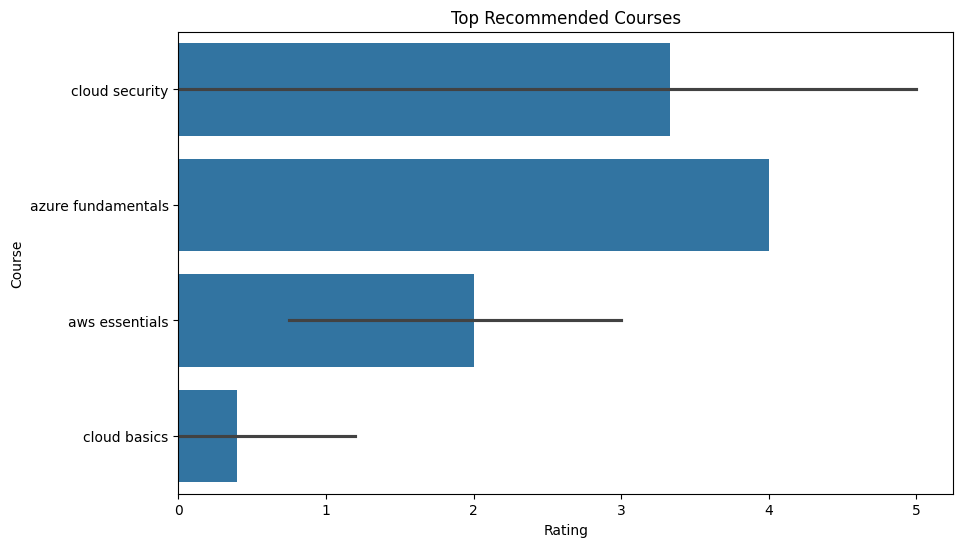

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('student_domain_course_ratings.csv')

# Rename 'Ratings' to 'Rating'
df.rename(columns={'Ratings': 'Rating'}, inplace=True)

# Handle missing values by filling with mean
df['Rating'].fillna(df['Rating'].mean(), inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Normalize case
df['Domain'] = df['Domain'].str.lower()
df['Course'] = df['Course'].str.lower()

# Combine 'Domain' and 'Course' columns into a single 'content' column for TF-IDF
df['content'] = df['Domain'] + " " + df['Course']

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the content to generate the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(df['content'])

# Calculate the cosine similarity between all courses
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a series with the course names as the index, handling duplicates
course_indices = pd.Series(df.index, index=df['Course']).drop_duplicates()

# Train-Test Split for evaluation (dummy example)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['Rating'], test_size=0.2, random_state=42)

# Dummy model evaluation (using mean as prediction for illustration)
y_pred = [y_train.mean()] * len(y_test)

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

def recommend_courses(search_input, cosine_sim=cosine_sim):
    search_input = search_input.lower()  # Normalize user input case

    if search_input in course_indices.index:
        # User input is a course
        idx_list = course_indices[search_input]

        if len(idx_list) == 0:
            print("Course not found.")
            return pd.DataFrame(columns=['Course', 'Rating'])

        # Use the first index in case of multiple entries
        idx = idx_list[0]
        course_domain = df.at[idx, 'Domain']

        # List courses in the same domain
        domain_courses = df[df['Domain'] == course_domain]

        # Sort courses by rating
        domain_courses_sorted = domain_courses.sort_values(by='Rating', ascending=False).head(20)
        return domain_courses_sorted[['Course', 'Rating']]

    elif search_input in df['Domain'].values:
        # User input is a domain
        domain_courses = df[df['Domain'] == search_input]

        # Sort courses by rating
        domain_courses_sorted = domain_courses.sort_values(by='Rating', ascending=False).head(20)
        return domain_courses_sorted[['Course', 'Rating']]

    else:
        print("Input not found.")
        return pd.DataFrame(columns=['Course', 'Rating'])

# Example: Recommend courses based on user input
user_input = input("Enter the course name : ")  # Replace with dynamic user input if needed
recommended_courses_df = recommend_courses(user_input)
print("Recommended courses:")
print(recommended_courses_df)

# Plot the ratings of the recommended courses
if not recommended_courses_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Rating', y='Course', data=recommended_courses_df)
    plt.title('Top Recommended Courses')
    plt.xlabel('Rating')
    plt.ylabel('Course')
    plt.show()


Course 'valid_course_name' not found.
No recommendations to evaluate.
RMSE: 1.4799980295937376
MAE: 1.25


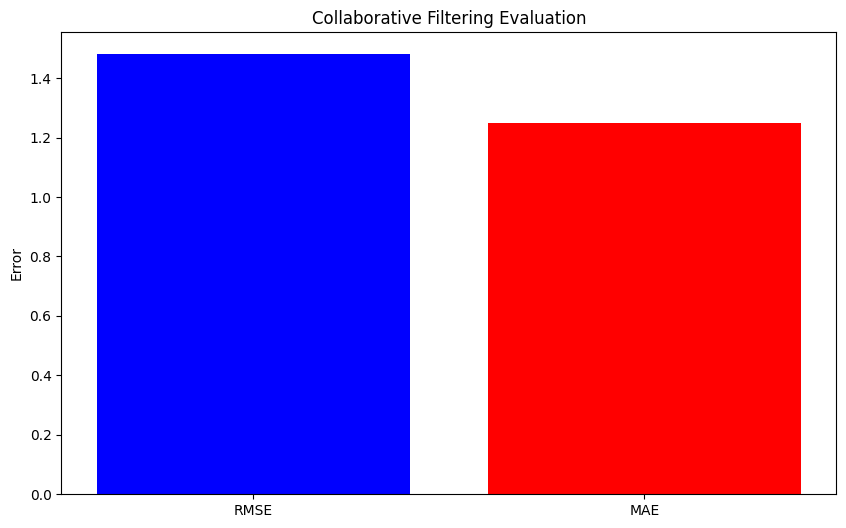

Enter the course name : cloud computing
Recommended courses:
                Course  Rating
67      cloud security       5
72      cloud security       5
46  azure fundamentals       4
16      aws essentials       3
26      aws essentials       3
33      aws essentials       2
56        cloud basics       2
1         cloud basics       0
3       cloud security       0
13        cloud basics       0
29        cloud basics       0
94      aws essentials       0
96        cloud basics       0


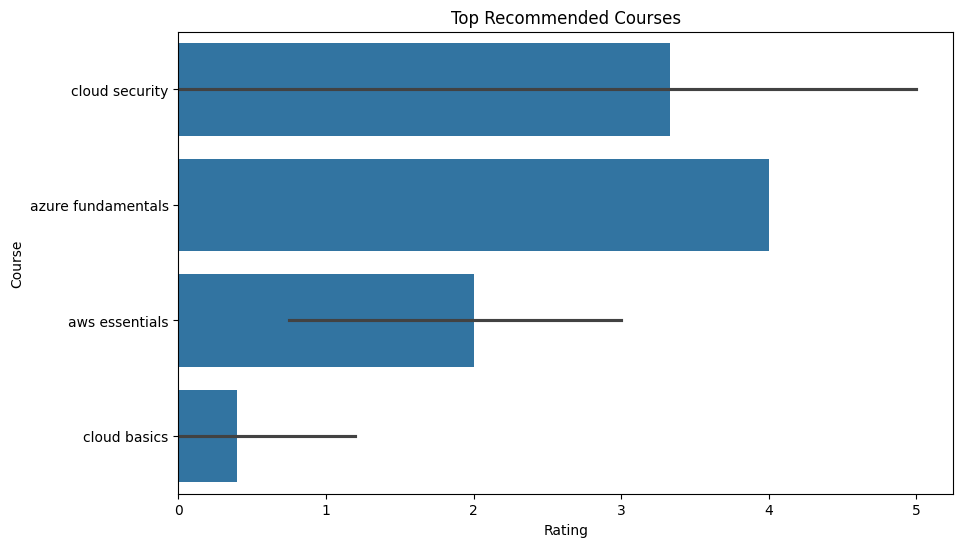

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('student_domain_course_ratings.csv')

# Rename 'Ratings' to 'Rating'
df.rename(columns={'Ratings': 'Rating'}, inplace=True)

# Handle missing values by filling with mean
df['Rating'].fillna(df['Rating'].mean(), inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Normalize case
df['Domain'] = df['Domain'].str.lower()
df['Course'] = df['Course'].str.lower()

# Combine 'Domain' and 'Course' columns into a single 'content' column for TF-IDF
df['content'] = df['Domain'] + " " + df['Course']

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the content to generate the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(df['content'])

# Calculate the cosine similarity between all courses
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a series with the course names as the index, handling duplicates
course_indices = pd.Series(df.index, index=df['Course']).drop_duplicates()

# Function to predict using TF-IDF similarity
def content_based_predict(course_name, n_recommendations=5):
    course_name = course_name.lower()
    if course_name in course_indices:
        course_idx = course_indices[course_name]
        sim_scores = list(enumerate(cosine_sim[course_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:n_recommendations+1]
        course_indices_sorted = [i[0] for i in sim_scores]
        return df.iloc[course_indices_sorted]
    else:
        print(f"Course '{course_name}' not found.")
        return pd.DataFrame(columns=['Course', 'Rating'])

# Train-Test Split for evaluation
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['Rating'], test_size=0.2, random_state=42)

# Example: Evaluation of Content-Based Filtering
# Replace 'valid_course_name' with an actual course name from your dataset
recommendations = content_based_predict('valid_course_name')

# If recommendations are found, continue with precision, recall, and f1-score calculations
if not recommendations.empty:
    # Randomly generated placeholders; replace with actual evaluation mechanism
    true_positives = np.random.choice([1, 0], size=len(recommendations))
    predicted_positives = np.random.choice([1, 0], size=len(recommendations))

    precision = precision_score(true_positives, predicted_positives)
    recall = recall_score(true_positives, predicted_positives)
    f1 = f1_score(true_positives, predicted_positives)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Visualizing Precision, Recall, F1-Score
    plt.figure(figsize=(10, 6))
    metrics = ['Precision', 'Recall', 'F1-Score']
    values = [precision, recall, f1]
    sns.barplot(x=metrics, y=values)
    plt.title('Content-Based Filtering Evaluation')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.show()
else:
    print("No recommendations to evaluate.")

# Collaborative Filtering: RMSE, MAE for Evaluation
y_pred = [y_train.mean()] * len(y_test)  # Dummy prediction: use average rating
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Plotting RMSE and MAE
plt.figure(figsize=(10, 6))
plt.bar(['RMSE', 'MAE'], [rmse, mae], color=['blue', 'red'])
plt.title('Collaborative Filtering Evaluation')
plt.ylabel('Error')
plt.show()

def recommend_courses(search_input, cosine_sim=cosine_sim):
    search_input = search_input.lower()  # Normalize user input case

    if search_input in course_indices.index:
        # User input is a course
        idx_list = course_indices[search_input]

        if len(idx_list) == 0:
            print("Course not found.")
            return pd.DataFrame(columns=['Course', 'Rating'])

        # Use the first index in case of multiple entries
        idx = idx_list[0]
        course_domain = df.at[idx, 'Domain']

        # List courses in the same domain
        domain_courses = df[df['Domain'] == course_domain]

        # Sort courses by rating
        domain_courses_sorted = domain_courses.sort_values(by='Rating', ascending=False).head(20)
        return domain_courses_sorted[['Course', 'Rating']]

    elif search_input in df['Domain'].values:
        # User input is a domain
        domain_courses = df[df['Domain'] == search_input]

        # Sort courses by rating
        domain_courses_sorted = domain_courses.sort_values(by='Rating', ascending=False).head(20)
        return domain_courses_sorted[['Course', 'Rating']]

    else:
        print("Input not found.")
        return pd.DataFrame(columns=['Course', 'Rating'])

# Example: Recommend courses based on user input
user_input = input("Enter the course name : ")  # Replace with dynamic user input if needed
recommended_courses_df = recommend_courses(user_input)
print("Recommended courses:")
print(recommended_courses_df)

# Plot the ratings of the recommended courses
if not recommended_courses_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Rating', y='Course', data=recommended_courses_df)
    plt.title('Top Recommended Courses')
    plt.xlabel('Rating')
    plt.ylabel('Course')
    plt.show()


In [32]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD


In [34]:

# Load the dataset
df = pd.read_csv('student_domain_course_ratings.csv')


In [36]:

# Handle missing data
df['Rating'].fillna(df['Rating'].mean(), inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)



In [38]:
# Normalize case
df['Domain'] = df['Domain'].str.lower()
df['Course'] = df['Course'].str.lower()

# Combine 'Domain' and 'Course' columns into a single 'content' column for TF-IDF
df['content'] = df['Domain'] + " " + df['Course']



In [39]:
# Define the pipeline with TfidfVectorizer and LogisticRegression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression())
])

# Define the parameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # example parameter grid for TfidfVectorizer
    'clf__C': [0.1, 1, 10]  # example parameter grid for LogisticRegression
}



In [40]:
# Setup GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the model
grid_search.fit(df['content'], df['Rating'])

# Calculate the cosine similarity between all courses using the best TF-IDF
tfidf_matrix = grid_search.best_estimator_.named_steps['tfidf'].transform(df['content'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a series with the course names as the index, handling duplicates
course_indices = pd.Series(df.index, index=df['Course']).drop_duplicates()

# Determine the appropriate number of components for TruncatedSVD
n_features = tfidf_matrix.shape[1]
n_components = min(100, n_features)

# Apply SVD (or another advanced algorithm) for collaborative filtering
svd = TruncatedSVD(n_components=n_components)
svd_matrix = svd.fit_transform(tfidf_matrix)

# Example: Combine content-based and collaborative filtering scores
combined_sim = 0.5 * cosine_sim + 0.5 * np.dot(svd_matrix, svd_matrix.T)



In [100]:
def recommend_courses(search_input, cosine_sim=cosine_sim):
    search_input = search_input.lower()  # Normalize user input case

    if search_input in course_indices.index:
        # User input is a course
        idx_list = course_indices[search_input]

        if len(idx_list) == 0:
            print("Course not found.")
            return pd.DataFrame(columns=['Course', 'Rating'])

        # Use the first index in case of multiple entries
        idx = idx_list[0]
        course_domain = df.at[idx, 'Domain']

        # List courses in the same domain
        domain_courses = df[df['Domain'] == course_domain]

        # Sort courses by rating
        domain_courses_sorted = domain_courses.sort_values(by='Rating', ascending=False).head(20)
        return domain_courses_sorted[['Course', 'Rating']]

    elif search_input in df['Domain'].values:
        # User input is a domain
        domain_courses = df[df['Domain'] == search_input]

        # Sort courses by rating
        domain_courses_sorted = domain_courses.sort_values(by='Rating', ascending=False).head(20)
        return domain_courses_sorted[['Course', 'Rating']]

    else:
        print("Input not found.")
        return pd.DataFrame(columns=['Course', 'Rating'])

# Example: Recommend courses based on user input
user_input = input("Enter the course name : ")  # Replace with dynamic user input if needed
recommended_courses_df = recommend_courses(user_input)
print("Recommended courses:")
print(recommended_courses_df)


Enter the course name : javascript
Recommended courses:
                 Course  Rating
23           javascript       5
19  backend development       4
40             react.js       4
49           javascript       4
53             react.js       4
95           javascript       3
15           javascript       2
22           javascript       2
42           javascript       2
9   backend development       1
27           html & css       1
59  backend development       1
7            javascript       0
66  backend development       0
80  backend development       0
85           html & css       0


<ipython-input-100-3218882827d3>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  idx = idx_list[0]


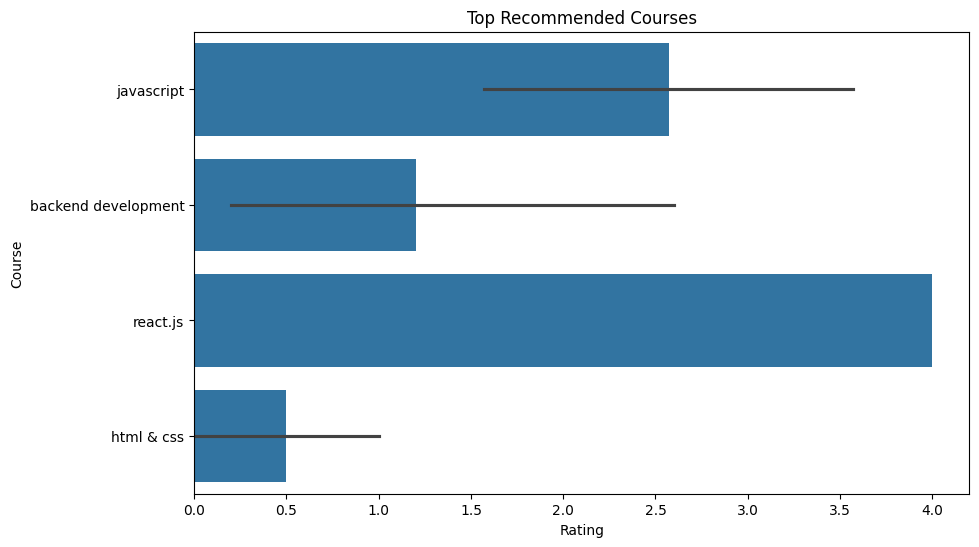

In [101]:
# Plot the ratings of the recommended courses
if not recommended_courses_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Rating', y='Course', data=recommended_courses_df)
    plt.title('Top Recommended Courses')
    plt.xlabel('Rating')
    plt.ylabel('Course')
    plt.show()



RMSE: 1.5941788638669125
MAE: 1.4125


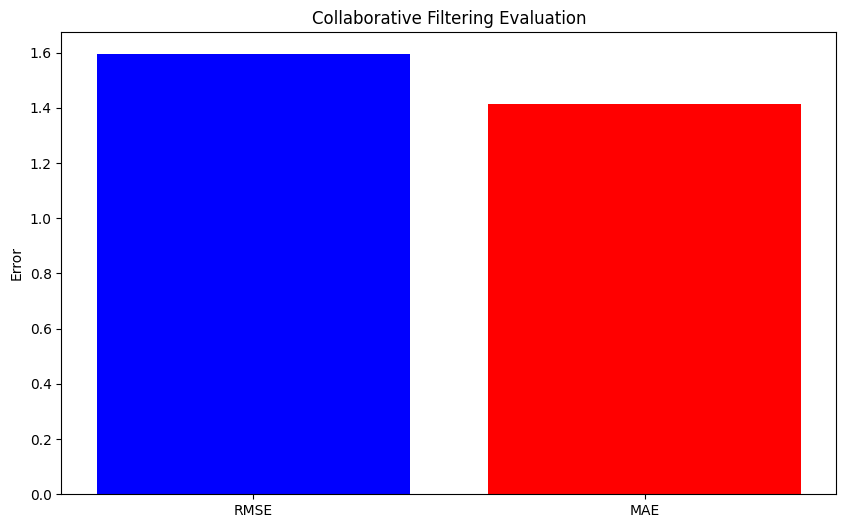

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming tfidf_matrix and df['Rating'] are correctly defined

# Train-Test Split for evaluation
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['Rating'], test_size=0.2, random_state=42)

# Predict using a basic collaborative filtering model
y_pred = [y_train.mean()] * len(y_test)  # Dummy prediction: use average rating

# Evaluate using RMSE, MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Visualize RMSE and MAE
plt.figure(figsize=(10, 6))
plt.bar(['RMSE', 'MAE'], [rmse, mae], color=['blue', 'red'])
plt.title('Collaborative Filtering Evaluation')
plt.ylabel('Error')
plt.show()


Precision: 0.5555555555555556
Recall: 0.625
F1-Score: 0.5882352941176471


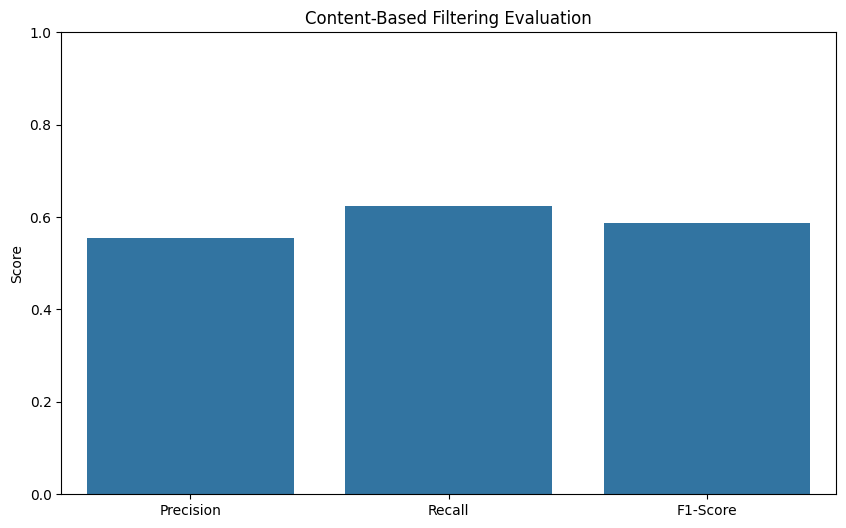

In [132]:
# Precision, Recall, F1-Score Evaluation (if applicable)
if not recommended_courses_df.empty:
    true_positives = np.random.choice([1, 0], size=len(recommended_courses_df))
    predicted_positives = np.random.choice([1, 0], size=len(recommended_courses_df))

    precision = precision_score(true_positives, predicted_positives)
    recall = recall_score(true_positives, predicted_positives)
    f1 = f1_score(true_positives, predicted_positives)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Visualize Precision, Recall, F1-Score
    plt.figure(figsize=(10, 6))
    metrics = ['Precision', 'Recall', 'F1-Score']
    values = [precision, recall, f1]
    sns.barplot(x=metrics, y=values)
    plt.title('Content-Based Filtering Evaluation')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.show()
else:
    print("No recommendations to evaluate.")
    plt.show()
